# 1. Dependencias
---

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *


# 2. Carga de datos 
---

In [2]:
df_admission = pd.read_csv("./data/HDHI_admission_data.csv")
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [3]:
# Limpiamos y renombramos las columnas originales del df
df_admission.columns = df_admission.columns.str.strip()

mapping = {
    'SNO': 'serial_number',
    'MRD No.': 'mrd_number',
    'D.O.A': 'admission_date',
    'D.O.D': 'discharge_date',
    'AGE': 'age',
    'GENDER': 'gender',
    'RURAL': 'residence_rural',
    'TYPE OF ADMISSION-EMERGENCY/OPD': 'admission_type',
    'month year': 'admission_month_year',
    'DURATION OF STAY': 'length_of_stay_days',
    'duration of intensive unit stay': 'icu_length_of_stay_days',
    'OUTCOME': 'hospital_outcome',
    'SMOKING': 'smoking_status',
    'ALCOHOL': 'alcohol_use',
    'DM': 'diabetes',
    'HTN': 'hypertension',
    'CAD': 'coronary_artery_disease',
    'PRIOR CMP': 'prior_cva',                     # CMP -> cerebrovascular accident (ajusta si tu significado es otro)
    'CKD': 'chronic_kidney_disease',
    'HB': 'hemoglobin_g_dl',
    'TLC': 'total_leukocyte_count',
    'PLATELETS': 'platelet_count',
    'GLUCOSE': 'glucose_mg_dl',
    'UREA': 'urea_mg_dl',
    'CREATININE': 'creatinine_mg_dl',
    'BNP': 'bnp',
    'RAISED CARDIAC ENZYMES': 'raised_cardiac_enzymes',
    'EF': 'ejection_fraction_percent',
    'SEVERE ANAEMIA': 'severe_anemia',
    'ANAEMIA': 'anemia',
    'STABLE ANGINA': 'stable_angina',
    'ACS': 'acute_coronary_syndrome',
    'STEMI': 'stemi',
    'ATYPICAL CHEST PAIN': 'atypical_chest_pain',
    'HEART FAILURE': 'heart_failure',
    'HFREF': 'hf_ref',                             # HFrEF (reduced EF)
    'HFNEF': 'hf_nef',                             # HFpEF/HFNEF (preserv. EF) — cambia si prefieres hf_pef
    'VALVULAR': 'valvular_disease',
    'CHB': 'complete_heart_block',
    'SSS': 'sick_sinus_syndrome',
    'AKI': 'acute_kidney_injury',
    'CVA INFRACT': 'cva_infarct',
    'CVA BLEED': 'cva_bleed',
    'AF': 'atrial_fibrillation',
    'VT': 'ventricular_tachycardia',
    'PSVT': 'psvt',
    'CONGENITAL': 'congenital_heart_disease',
    'UTI': 'urinary_tract_infection',
    'NEURO CARDIOGENIC SYNCOPE': 'neurocardiogenic_syncope',
    'ORTHOSTATIC': 'orthostatic_hypotension',
    'INFECTIVE ENDOCARDITIS': 'infective_endocarditis',
    'DVT': 'deep_vein_thrombosis',
    'CARDIOGENIC SHOCK': 'cardiogenic_shock',
    'SHOCK': 'shock',
    'PULMONARY EMBOLISM': 'pulmonary_embolism',
    'CHEST INFECTION': 'chest_infection'
}

df_admission.rename(columns=mapping, inplace=True)

In [4]:
# Estructura del dataset
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15757 entries, 0 to 15756
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   serial_number              15757 non-null  int64 
 1   mrd_number                 15757 non-null  object
 2   admission_date             15757 non-null  object
 3   discharge_date             15757 non-null  object
 4   age                        15757 non-null  int64 
 5   gender                     15757 non-null  object
 6   residence_rural            15757 non-null  object
 7   admission_type             15757 non-null  object
 8   admission_month_year       15757 non-null  object
 9   length_of_stay_days        15757 non-null  int64 
 10  icu_length_of_stay_days    15757 non-null  int64 
 11  hospital_outcome           15757 non-null  object
 12  smoking_status             15757 non-null  int64 
 13  alcohol_use                15757 non-null  int64 
 14  diabet

In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 737 non-null    object 
 1   AQI                  737 non-null    int64  
 2   PM2.5 AVG            737 non-null    int64  
 3   PM2.5 MIN            737 non-null    int64  
 4   PM2.5 MAX            737 non-null    int64  
 5   PM10 AVG             737 non-null    int64  
 6   PM10 MIN             737 non-null    int64  
 7   PM10 MAX             737 non-null    object 
 8   NO2 AVG              737 non-null    int64  
 9   NO2 MIN              737 non-null    int64  
 10  NO2 MAX              737 non-null    object 
 11  NH3 AVG              737 non-null    int64  
 12  NH3 MIN              737 non-null    int64  
 13  NH3 MAX              737 non-null    int64  
 14  SO2 AVG              737 non-null    int64  
 15  SO2 MIN              737 non-null    int

In [6]:
df_admission.head()

,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0


In [169]:
df_weather.head()

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-03-25,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,2017-03-26,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,2017-03-27,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,2017-03-28,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,2017-03-29,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [ ]:
# mapa para convertir 'Apr-17' -> 4, 'Mar-19' -> 3, etc.
_MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
}

def parse_with_disambiguation(
    df,
    date_col,
    month_hint_col=None,
    admission_col=None,
    los_col=None,
    tolerance=2
):
    """
    Convierte una columna de fechas que viene mezclada (DD/MM/YYYY vs MM/DD/YYYY),
    y si se trata de 'discharge_date', valida usando length_of_stay_days.

    Funcionalidades:
    - Hace dos parses: dayfirst y monthfirst.
    - Si solo uno funciona, usa ese.
    - Si los dos funcionan pero dan meses distintos, usa la pista de month_hint_col (si existe).
    - Si la columna corresponde a una fecha de alta (usa admission_col y los_col),
      recalcula discharge_date = admission_date + length_of_stay_days
      cuando la diferencia entre fechas difiere más que el parámetro `tolerance`.
    """

    raw = df[date_col].astype(str)

    # 1️⃣ Dos intentos de parseo
    d_dayfirst = pd.to_datetime(raw, errors='coerce', dayfirst=True)
    d_monthfirst = pd.to_datetime(raw, errors='coerce', dayfirst=False)

    # 2️⃣ Base: usar el que no sea NaT
    result = d_dayfirst.fillna(d_monthfirst)

    # 3️⃣ Filas ambiguas: ambos válidos pero con meses distintos
    amb_mask = (
        d_dayfirst.notna()
        & d_monthfirst.notna()
        & (d_dayfirst.dt.month != d_monthfirst.dt.month)
    )

    if month_hint_col is not None and month_hint_col in df.columns:
        # Extraer el mes esperado del hint (ej. 'Apr-17' -> 4)
        hint_str = df.loc[amb_mask, month_hint_col].astype(str).str[:3]
        hint_month = hint_str.map(_MONTH_MAP)

        # Elegir según coincidencia con el mes esperado
        use_dayfirst = d_dayfirst.loc[amb_mask].dt.month.eq(hint_month)
        chosen = d_dayfirst.loc[amb_mask].where(use_dayfirst, d_monthfirst.loc[amb_mask])
        result.loc[amb_mask] = chosen
    else:
        # Sin pista → priorizamos month-first
        result.loc[amb_mask] = d_monthfirst.loc[amb_mask]

    # 4️⃣ Si se trata de discharge_date, validar con length_of_stay_days
    if admission_col and los_col and all(col in df.columns for col in [admission_col, los_col]):
        adm = pd.to_datetime(df[admission_col], errors="coerce")
        los = df[los_col]

        # Calcular diferencia actual
        stay_diff = (result - adm).dt.days

        # Detectar inconsistencias (mayor al margen permitido)
        bad_mask = stay_diff.sub(los).abs() > tolerance

        if bad_mask.any():
            print(f"{bad_mask.sum()} fechas inconsistentes detectadas en '{date_col}', recalculando...")

            # Recalcular discharge_date = admission_date + length_of_stay_days
            result.loc[bad_mask] = adm.loc[bad_mask] + pd.to_timedelta(los.loc[bad_mask], unit="D")

        # Verificación final
        new_diff = (result - adm).dt.days
        inconsistentes = (new_diff.sub(los).abs() > tolerance).sum()
        if inconsistentes:
            print(f"{inconsistentes} filas aún no coinciden tras la corrección en '{date_col}'.")

    return result


In [8]:
# Parsear admission_date usando la pista de mes
df_admission['admission_date'] = parse_with_disambiguation(
    df_admission,
    date_col='admission_date',
    month_hint_col='admission_month_year'
)

# Parsear discharge_date verificando coherencia con length_of_stay_days
df_admission['discharge_date'] = parse_with_disambiguation(
    df_admission,
    date_col='discharge_date',
    month_hint_col=None,  # no siempre disponible
    admission_col='admission_date',
    los_col='length_of_stay_days',
    tolerance=2
)


df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

df_admission.head(10)

3552 fechas inconsistentes detectadas en 'discharge_date', recalculando...


,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,2017-04-01,2017-04-03,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,2017-04-01,2017-04-05,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,2017-04-01,2017-04-23,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
5,6,234675,2017-04-01,2017-04-10,44,M,U,E,Apr-17,10,...,0,0,0,0,0,0,0,0,0,0
6,7,234563,2017-04-01,2017-04-06,56,F,U,E,Apr-17,6,...,0,0,0,0,0,0,0,0,0,0
7,8,208455,2017-04-01,2017-04-13,47,M,U,E,Apr-17,13,...,0,0,0,0,0,0,0,0,0,0
8,9,67070,2017-04-01,2017-04-03,65,F,U,E,Apr-17,3,...,0,0,0,0,0,0,0,1,0,0
9,10,153218,2017-04-01,2017-04-03,59,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_weather.head(5)

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-03-25,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,2017-03-26,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,2017-03-27,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,2017-03-28,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,2017-03-29,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [10]:
# Mostramos los valores nulos
df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
discharge_date                  1
admission_type                  0
gender                          0
age                             0
admission_date                  0
residence_rural                 0
icu_length_of_stay_days         0
length_of_stay_days             0
hypertension                    0
diabetes                        0
alcohol_use                     0
smoking_status                  0
hospital_outcome                0
admission_month_year            0
mrd_number                      0
serial_number                   0
prior_cva                       0
coronary_artery_disease         0
chronic_kidney_disease          0
raised_cardiac_enzymes          0
severe_anemia                   0
anemia        

###  Imputación de `admission_date` y `discharge_date` faltantes

En algunos registros, la fecha de admisión (`discharge_date`) está ausente (`NaT`), 
pero sí se dispone de la fecha de alta (`admission_date`) y la duración de la internación (`length_of_stay_days`). 

Para estos casos, se puede estimar la fecha utilizando la duracion de la internacion (`length_of_stay_days`).

Esta imputación permite conservar consistencia temporal en los análisis de admisiones y estancias.


In [11]:
# Creamos una máscara para filas con fecha de admisión faltante pero con datos válidos
mask = (
  df_admission['admission_date'].isna() & 
  df_admission['discharge_date'].notna() & 
  df_admission['length_of_stay_days'].notna()
)

# Accedemos a todas las filas donde la mascara sea True y realizamos la imputacion
df_admission.loc[mask, 'admission_date'] = (
  df_admission.loc[mask, 'discharge_date'] - 
  pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)


In [12]:
# Creamos una máscara para filas con fecha de alta faltante pero con datos válidos
mask = (df_admission['admission_date'].notna() &
        df_admission['length_of_stay_days'].notna() & 
        df_admission['discharge_date'].isna()        
)

df_admission.loc[mask, 'discharge_date'] = (
        df_admission.loc[mask, 'admission_date'] + 
        pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)

In [13]:
# Eliminamos las filas que tanto 'admission_date' como 'discharge_date' son nulas
df_admission = df_admission.dropna(subset = ['admission_date', 'discharge_date'], how='all')

df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
admission_type                  0
residence_rural                 0
gender                          0
age                             0
discharge_date                  0
admission_month_year            0
icu_length_of_stay_days         0
length_of_stay_days             0
hypertension                    0
diabetes                        0
alcohol_use                     0
smoking_status                  0
hospital_outcome                0
serial_number                   0
admission_date                  0
mrd_number                      0
prior_cva                       0
coronary_artery_disease         0
chronic_kidney_disease          0
raised_cardiac_enzymes          0
severe_anemia                   0
anemia        

In [172]:
# Exportamos df_admission limpio
df_admission.to_csv('./data/cleaned_admission_data.csv', index=False)

# 3. Serie temporal: cantidad de pacientes hospitalizados por día
---

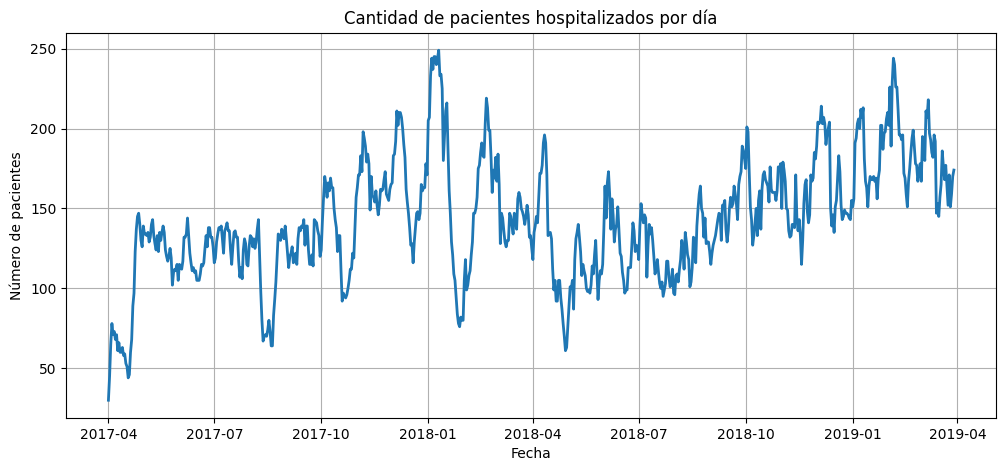

In [171]:

# Expandir el rango de fechas por paciente
df_expanded = (
    df_admission
    .apply(lambda row: pd.date_range(row['admission_date'], row['discharge_date'], freq='D'), axis=1)
    .explode()
    .to_frame(name='date')
)

# Agregar el ID del paciente
df_expanded['serial_number'] = df_admission.loc[df_expanded.index, 'serial_number'].values

# Agrupamos por fecha y contamos
daily_counts = (
    df_expanded
    .groupby('date')
    .size()
    .reset_index(name='num_patients')
)

# Excluimos los ultimos 25 valores ya que sesgan el modelo
daily_counts = daily_counts.iloc[:-25]

# exportar daily_counts a un csv
daily_counts.to_csv('./data/daily_hospitalized_patients.csv', index=False)

# Graficamos la serie temporal
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()


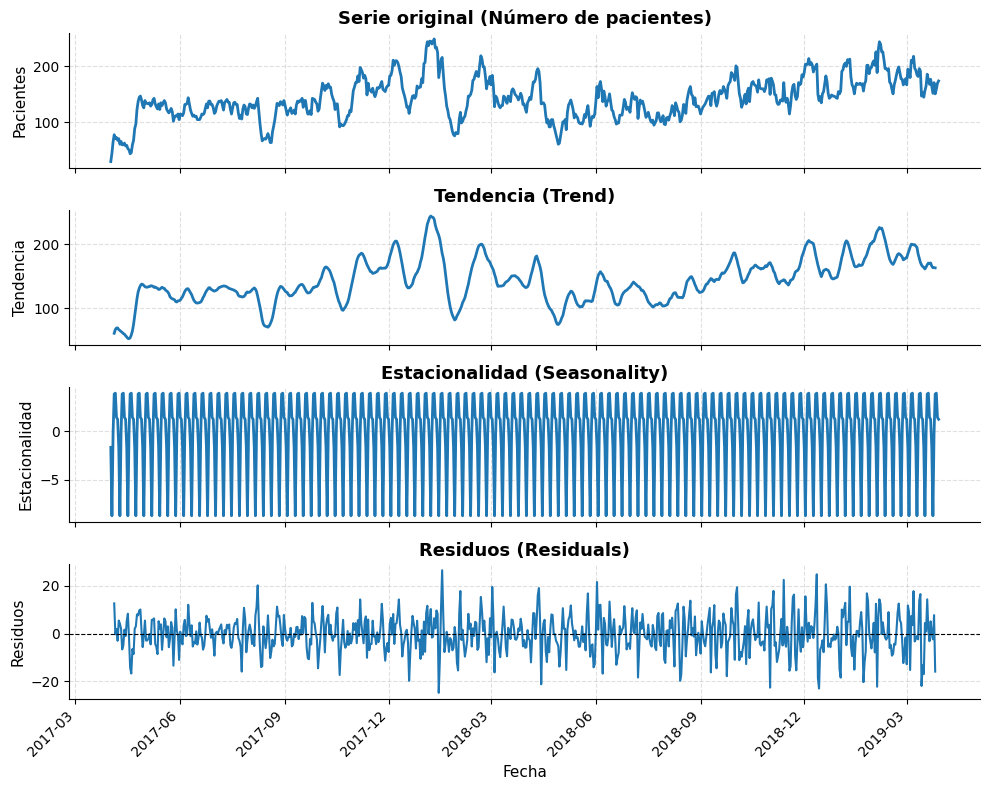

In [91]:
ts = daily_counts.copy()
ts['date'] = pd.to_datetime(ts['date'])
ts = ts.set_index('date').sort_index()

# Asegurar frecuencia diaria y rellenar días faltantes con 0
ts = ts.asfreq('D', fill_value=0)

# Descomposición aditiva (period=7 para estacionalidad semanal)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['num_patients'], model='additive', period=7)

# Plot personalizado usando el índice datetime (los formatters funcionarán correctamente)
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Serie original
axes[0].plot(ts.index, result.observed, linewidth=2)
axes[0].set_title('Serie original (Número de pacientes)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Pacientes', fontsize=11)

# Tendencia
axes[1].plot(ts.index, result.trend, linewidth=2)
axes[1].set_title('Tendencia (Trend)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Tendencia', fontsize=11)

# Estacionalidad
axes[2].plot(ts.index, result.seasonal, linewidth=2)
axes[2].set_title('Estacionalidad (Seasonality)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Estacionalidad', fontsize=11)

# Residuos
axes[3].plot(ts.index, result.resid, linewidth=1.5)
axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[3].set_title('Residuos (Residuals)', fontsize=13, fontweight='bold')
axes[3].set_ylabel('Residuos', fontsize=11)
axes[3].set_xlabel('Fecha', fontsize=11)

# --- Formatear eje X con fechas ---
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[3].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # cada 3 meses
fig.autofmt_xdate(rotation=45)

# Ajustes estéticos
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_118221/167714925.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_male, data_female],


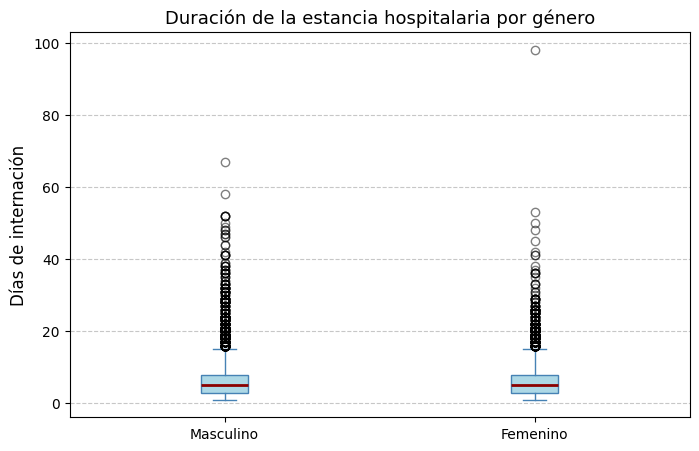

In [16]:

# Filtramos datos válidos (sin NaN en las dos columnas)
df_valid = df_admission.dropna(subset=['length_of_stay_days', 'gender'])

# Agrupamos los datos por género
data_male = df_valid.loc[df_valid['gender'] == 'M', 'length_of_stay_days']
data_female = df_valid.loc[df_valid['gender'] == 'F', 'length_of_stay_days']

# Creamos el boxplot
plt.figure(figsize=(8,5))
plt.boxplot([data_male, data_female],
            labels=['Masculino', 'Femenino'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='steelblue'),
            medianprops=dict(color='darkred', linewidth=2),
            whiskerprops=dict(color='steelblue'),
            capprops=dict(color='steelblue'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title('Duración de la estancia hospitalaria por género', fontsize=13)
plt.ylabel('Días de internación', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:
daily_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          728 non-null    datetime64[ns]
 1   num_patients  728 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [18]:
daily_counts.tail(20)

,date,num_patients
708,2019-03-10,185
709,2019-03-11,182
710,2019-03-12,196
711,2019-03-13,192
712,2019-03-14,147
713,2019-03-15,153
714,2019-03-16,145
715,2019-03-17,157
716,2019-03-18,165
717,2019-03-19,186


## Modelos base

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

/home/fausto/Documentos/facultad/Inteligencia Computacional/hospital-bed-prediction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Ajustar formato del DataFrame ---
# Cargar daily_counts si no está definido
if 'daily_counts' not in locals() and 'daily_counts' not in globals():
    daily_counts = pd.read_csv('./data/daily_hospitalized_patients.csv')
    daily_counts['date'] = pd.to_datetime(daily_counts['date'])

df = daily_counts.rename(columns={
    'date': 'ds',
    'num_patients': 'y'
})
df['unique_id'] = 'PACIENTES'

df.head()

,ds,y,unique_id
0,2017-04-01,30,PACIENTES
1,2017-04-02,45,PACIENTES
2,2017-04-03,65,PACIENTES
3,2017-04-04,78,PACIENTES
4,2017-04-05,71,PACIENTES


In [77]:
# Cantidad de dias que vamos a realizar nuestro pronostico
horizon = 7

models = [
  Naive(), 
  HistoricAverage(), 
  WindowAverage(window_size=horizon), 
  SeasonalNaive(season_length=horizon)
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [63]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,PACIENTES,2019-03-30,174.0,142.736267,167.666672,159.0
1,PACIENTES,2019-03-31,174.0,142.736267,167.666672,170.0
2,PACIENTES,2019-04-01,174.0,142.736267,167.666672,174.0


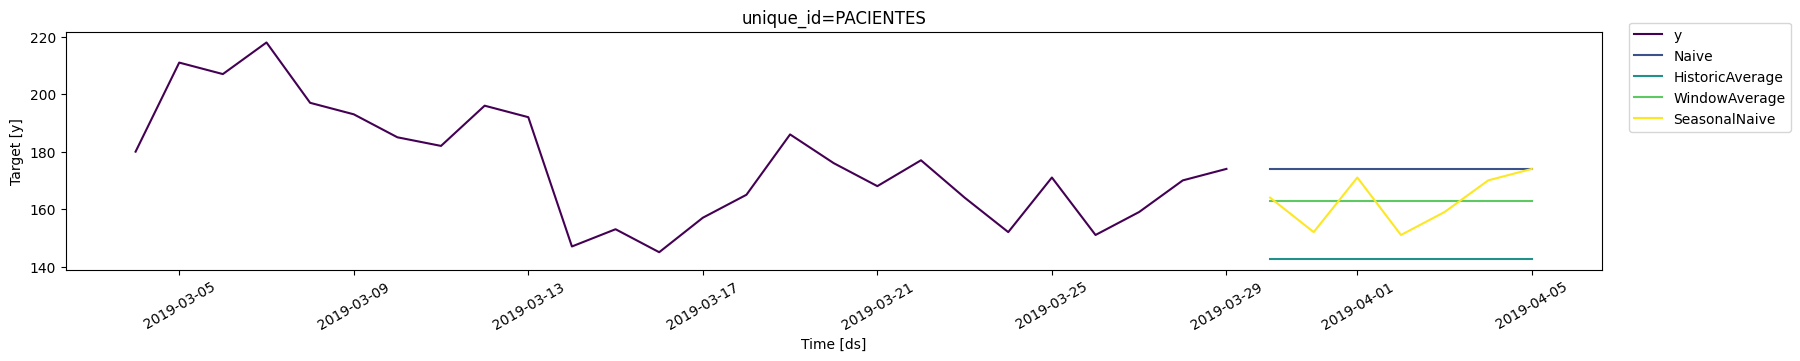

In [78]:
plot_series(
  df = df, 
  forecasts_df=preds, 
  ids=["PACIENTES"], 
  max_insample_length=26, 
  palette="viridis"
)


Estos pronosticos no son muy interesantes ya que tres de ellos, son promedios y la otra (SeasonalNaive) simplemente repite los datos de los ultimos siete dias

## Evaluacion de los modelos base

In [79]:
test = df.groupby("unique_id").tail(horizon)
train = df.drop(test.index).reset_index(drop=True)

In [80]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id']) 

In [81]:
evaluation = evaluate(
  eval_df, 
  metrics=[mae, rmse], 
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,PACIENTES,mae,14.00000,20.460464,8.102040,12.428571
1,PACIENTES,rmse,16.42298,22.188846,9.794831,16.686179


## Modelo ARIMA

In [82]:
from statsforecast.models import AutoARIMA

In [85]:
unique_ids = ['PACIENTES']
small_train = train[train['unique_id'].isin(unique_ids)]
small_test = test[test['unique_id'].isin(unique_ids)]

models = [
  AutoARIMA(seasonal=False, alias="ARIMA"), 
  AutoARIMA(season_length=horizon, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
  arima_eval_df, 
  metrics=[mae], 
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,PACIENTES,mae,14.0,16.478333,14.0,20.460464,8.10204,12.428571


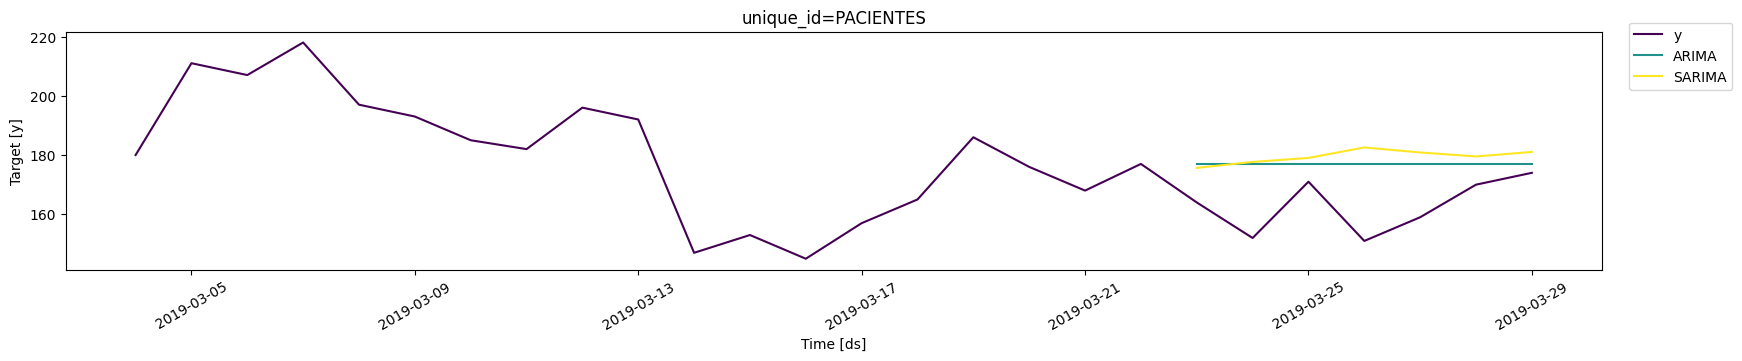

In [84]:
plot_series(
  df = df, 
  forecasts_df=arima_preds,
  ids=["PACIENTES"],
  max_insample_length=26,
  palette="viridis"
)

## Validacion cruzada

In [119]:
small_df = df[df['unique_id'].isin(unique_ids)]
models = [
  WindowAverage(window_size=horizon),
  SeasonalNaive(season_length=horizon),
  AutoARIMA(seasonal=False, alias="ARIMA"),
  AutoARIMA(season_length=horizon, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
cv_df = sf.cross_validation(
  h = horizon, 
  df=small_df, 
  n_windows=8,
  step_size=horizon, 
  refit=True # Reajusta el modelo en cada ventana
  )

cv_df.head()

,unique_id,ds,cutoff,y,WindowAverage,SeasonalNaive,ARIMA,SARIMA
0,PACIENTES,2019-02-02,2019-02-01,226.0,200.285721,202.0,202.0,200.876999
1,PACIENTES,2019-02-03,2019-02-01,189.0,200.285721,187.0,202.0,198.133072
2,PACIENTES,2019-02-04,2019-02-01,229.0,200.285721,197.0,202.0,199.962357
3,PACIENTES,2019-02-05,2019-02-01,244.0,200.285721,198.0,202.0,200.145294
4,PACIENTES,2019-02-06,2019-02-01,240.0,200.285721,206.0,202.0,201.608719


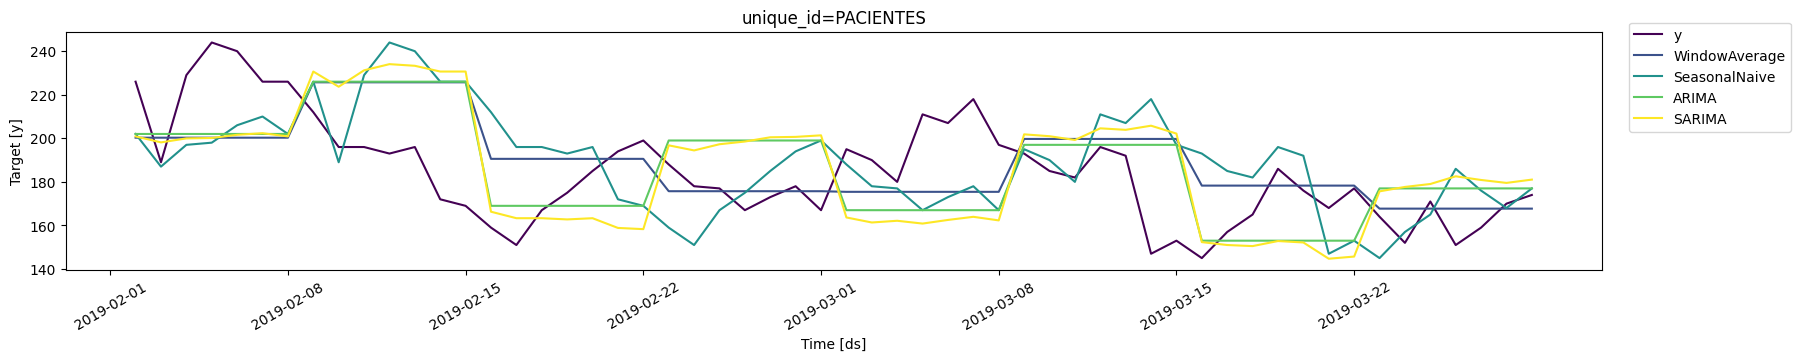

In [124]:
plot_series(
  df = df, 
  forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
  ids=["PACIENTES"],
  max_insample_length=56,
  palette="viridis"
)

In [126]:
cv_eval = evaluate(
  cv_df.drop(["cutoff"], axis=1), 
  metrics=[mae], 
)

cv_eval

,unique_id,metric,WindowAverage,SeasonalNaive,ARIMA,SARIMA
0,PACIENTES,mae,19.262753,24.196428,23.017857,25.991278


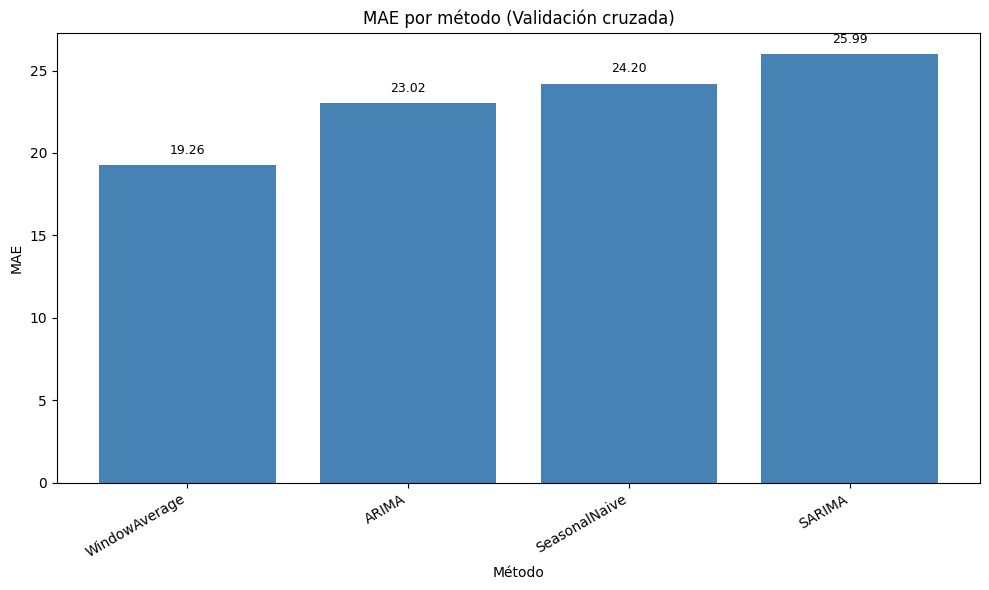

In [132]:
mae_df = cv_eval[cv_eval['metric'] == 'mae'].copy()

# Eliminar columnas identificadoras
drop_cols = [c for c in ['unique_id', 'metric'] if c in mae_df.columns]
models_df = mae_df.drop(columns=drop_cols)

# Forzar a numérico (coerce) y promediar si hay múltiples filas
numeric = models_df.apply(pd.to_numeric, errors='coerce')
vals = numeric.mean(axis=0) if numeric.shape[0] > 1 else numeric.iloc[0]

# Eliminar columnas no numéricas/NaN y ordenar (menor MAE primero)
vals = vals.dropna().sort_values(ascending=True)


plt.figure(figsize=(10, 6))
bars = plt.bar(vals.index, vals.values, color='steelblue')
plt.title('MAE por método (Validación cruzada)')
plt.ylabel('MAE')
plt.xlabel('Método')
plt.xticks(rotation=30, ha='right')
ymax = vals.values.max()
for bar in bars:
  h = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, h + 0.02 * ymax, f"{h:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [133]:
df_weather.head()

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-03-25,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,2017-03-26,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,2017-03-27,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,2017-03-28,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,2017-03-29,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


## Variables exogenas

In [140]:
daily_counts['date'] = pd.to_datetime(daily_counts['date'], errors='coerce')
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce')

# Columnas de interés (ajusta nombres si en tu CSV son distintos)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
df_exogen = pd.merge(daily_counts, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_exogen = df_exogen.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_exogen.columns:
        df_exogen[col] = pd.to_numeric(df_exogen[col], errors='coerce')


mean_humidity = df_exogen['humidity'].mean()
df_exogen['humidity'] = df_exogen['humidity'].fillna(mean_humidity).round(2)

df_exogen.info()
df_exogen.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          728 non-null    datetime64[ns]
 1   num_patients  728 non-null    int64         
 2   aqi           728 non-null    int64         
 3   max_temp      728 non-null    int64         
 4   min_temp      728 non-null    int64         
 5   humidity      728 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 34.2 KB


,date,num_patients,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,52,40,24,16.0
1,2017-04-02,45,59,40,21,14.0
2,2017-04-03,65,70,39,22,14.0
3,2017-04-04,78,70,39,23,23.0
4,2017-04-05,71,88,36,20,51.0


In [141]:
# --- Ajustar formato del DataFrame (usar df_exogen con variables exógenas) ---
df = df_exogen.rename(columns={'date': 'ds', 'num_patients': 'y'}) if 'df_exogen' in globals() else daily_counts.rename(columns={'date': 'ds', 'num_patients': 'y'})

# Asegurar tipo datetime en ds
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

# Añadir identificador requerido por StatsForecast
df['unique_id'] = 'PACIENTES'

# Reordenar columnas para que ds, y, unique_id estén al inicio
cols = ['ds', 'y', 'unique_id'] + [c for c in df.columns if c not in ['ds', 'y', 'unique_id']]
df = df[cols]

df.head()

,ds,y,unique_id,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,PACIENTES,52,40,24,16.0
1,2017-04-02,45,PACIENTES,59,40,21,14.0
2,2017-04-03,65,PACIENTES,70,39,22,14.0
3,2017-04-04,78,PACIENTES,70,39,23,23.0
4,2017-04-05,71,PACIENTES,88,36,20,51.0


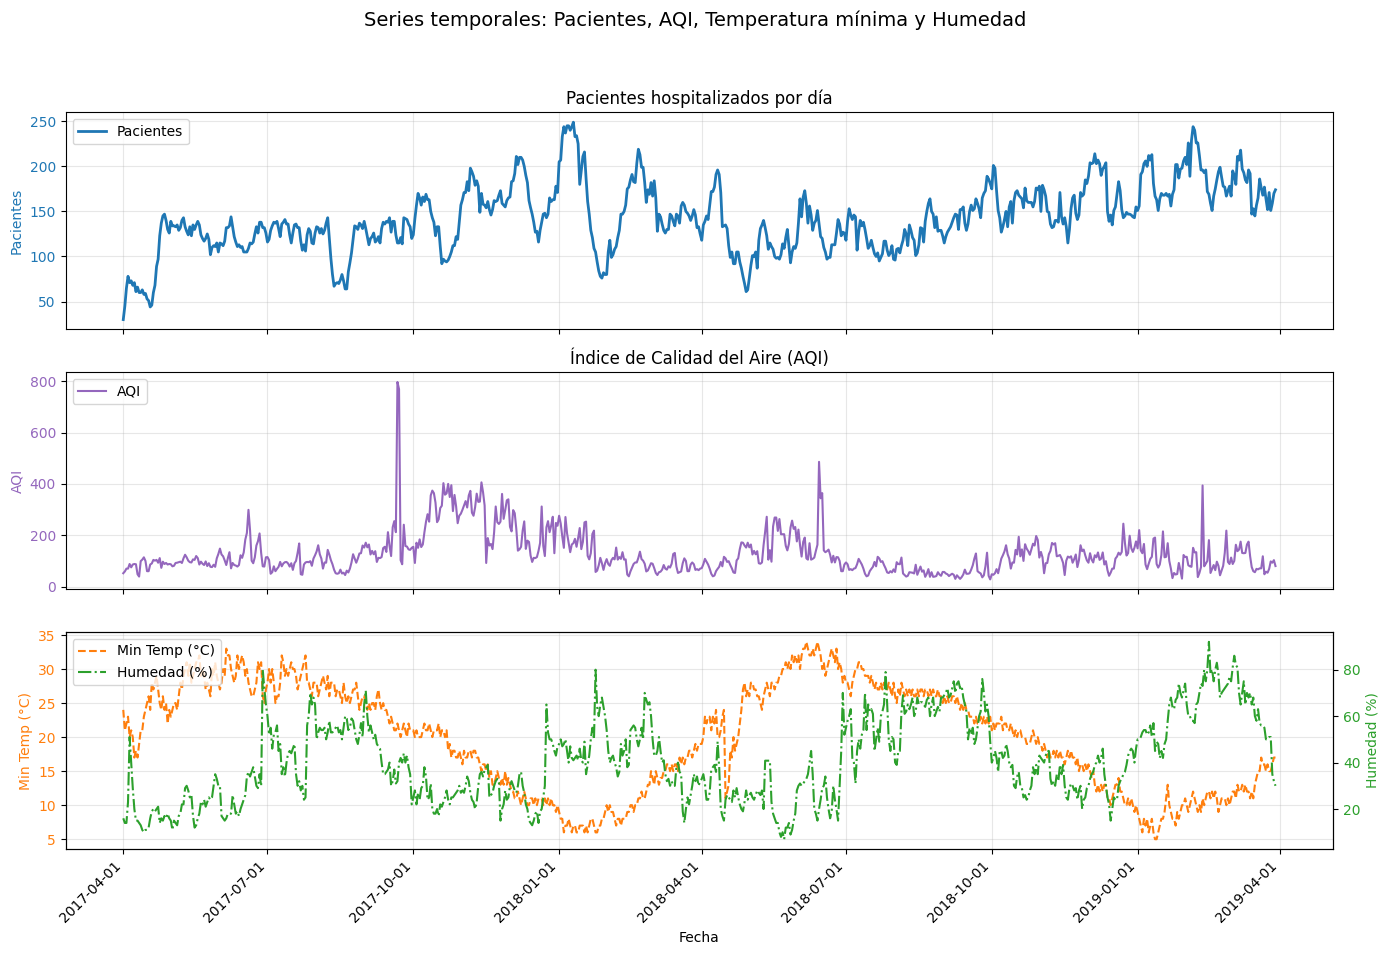

In [145]:
df = df.sort_values('ds').reset_index(drop=True)
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
ax0, ax1, ax2 = axes

# Ax 0: Pacientes
ax0.plot(df['ds'], df['y'], color='tab:blue', linewidth=2, label='Pacientes')
ax0.set_ylabel('Pacientes', color='tab:blue')
ax0.tick_params(axis='y', labelcolor='tab:blue')
ax0.set_title('Pacientes hospitalizados por día')
ax0.grid(alpha=0.3)
ax0.legend(loc='upper left')

# Ax 1: AQI
if 'aqi' in df.columns:
    ax1.plot(df['ds'], df['aqi'], color='tab:purple', linewidth=1.5, label='AQI')
    ax1.set_ylabel('AQI', color='tab:purple')
    ax1.tick_params(axis='y', labelcolor='tab:purple')
    ax1.set_title('Índice de Calidad del Aire (AQI)')
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.3)
else:
    ax1.text(0.5, 0.5, "Columna 'aqi' no encontrada", ha='center', va='center', transform=ax1.transAxes)
    ax1.set_ylabel('')
    ax1.set_title('AQI')

# Ax 2: Min Temp (eje izquierdo) y Humedad (eje derecho)
ax2.set_xlabel('Fecha')
if 'min_temp' in df.columns:
    ax2.plot(df['ds'], df['min_temp'], color='tab:orange', linestyle='--', linewidth=1.5, label='Min Temp (°C)')
    ax2.set_ylabel('Min Temp (°C)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
else:
    ax2.set_ylabel('')
ax2.grid(alpha=0.3)

ax2b = ax2.twinx()
if 'humidity' in df.columns:
    ax2b.plot(df['ds'], df['humidity'], color='tab:green', linestyle='-.', linewidth=1.5, label='Humedad (%)')
    ax2b.set_ylabel('Humedad (%)', color='tab:green')
    ax2b.tick_params(axis='y', labelcolor='tab:green')
else:
    ax2b.set_ylabel('')

# Leyenda combinada para el tercer eje
lines, labels = [], []
for a in (ax2, ax2b):
    for line in a.get_lines():
        lines.append(line)
        labels.append(line.get_label())
if lines:
    ax2.legend(lines, labels, loc='upper left')

# Formato eje x
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate(rotation=45)

plt.suptitle('Series temporales: Pacientes, AQI, Temperatura mínima y Humedad', fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [164]:
unique_ids = ['PACIENTES']
small_df = df[df['unique_id'].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(horizon)
train = small_df.drop(test.index).reset_index(drop=True)

In [165]:
futr_exog_df = test.drop("y", axis=1)
futr_exog_df

,ds,unique_id,aqi,max_temp,min_temp,humidity
721,2019-03-23,PACIENTES,58,29,15,50.0
722,2019-03-24,PACIENTES,54,28,16,50.0
723,2019-03-25,PACIENTES,69,27,15,51.0
724,2019-03-26,PACIENTES,98,29,15,51.0
725,2019-03-27,PACIENTES,93,30,16,35.0
726,2019-03-28,PACIENTES,103,31,17,32.0
727,2019-03-29,PACIENTES,80,32,17,30.0


In [166]:
models = [
  AutoARIMA(seasonal=False, alias="ARIMA with Exog"),
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
sf.fit(df=train)

# Prediccion con variables exógenas
arima_exog_preds = sf.predict(h=horizon, X_df = futr_exog_df)

models = [
  AutoARIMA(seasonal=False, alias="ARIMA"),
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
sf.fit(df=train.drop(columns=['aqi', 'max_temp', 'min_temp', 'humidity'], axis=1))

# Prediccion con variables exógenas
arima_preds = sf.predict(h=horizon)


In [167]:
test_df = pd.merge(arima_exog_preds, test, 'left', ['ds', 'unique_id'])
test_df = pd.merge(arima_preds, test_df, 'left', ['ds', 'unique_id'])

test_df

,unique_id,ds,ARIMA,ARIMA with Exog,y,aqi,max_temp,min_temp,humidity
0,PACIENTES,2019-03-23,177.0,173.485127,164,58,29,15,50.0
1,PACIENTES,2019-03-24,177.0,173.058387,152,54,28,16,50.0
2,PACIENTES,2019-03-25,177.0,170.045665,171,69,27,15,51.0
3,PACIENTES,2019-03-26,177.0,170.978806,151,98,29,15,51.0
4,PACIENTES,2019-03-27,177.0,166.886190,159,93,30,16,35.0
5,PACIENTES,2019-03-28,177.0,166.648589,170,103,31,17,32.0
6,PACIENTES,2019-03-29,177.0,164.218486,174,80,32,17,30.0


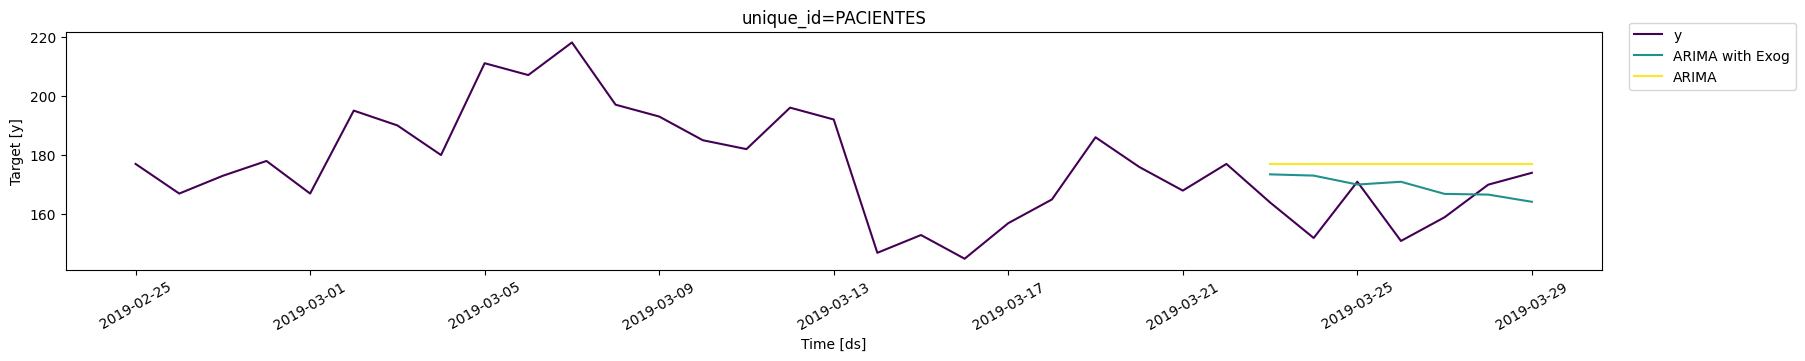

In [168]:
plot_series(
  df = train, 
  forecasts_df=test_df,
  ids=["PACIENTES"],
  max_insample_length=26,
  models=["ARIMA with Exog", "ARIMA"],
  palette="viridis"
)